# Autoencodeurs Variationnels Conditionnels

Ce notebook implémente un Autoencodeur Variationnel Conditionnel (CVAE) pour la génération d'images conditionnées sur les classes en utilisant le dataset MNIST. Le CVAE étend l'architecture VAE standard en incorporant des informations de labels pour contrôler le processus de génération.

## Objectifs d'apprentissage
- Comprendre l'architecture des Autoencodeurs Variationnels Conditionnels
- Implémenter un CVAE en utilisant PyTorch et Lightning
- Entraîner le modèle sur le dataset MNIST
- Générer des échantillons conditionnés sur des classes spécifiques

## Imports 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions
import lightning.pytorch as pl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Le dataset fashion-MNIST
Le code suivant charge le dataset fashion-MNIST et construit les dataloaders nécessaires pour l'entraînement.

In [16]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(
    root='fashion', 
    train=True, 
    download=True, 
    transform=transform
)

# Jeu de test (Test Set)
test_dataset = torchvision.datasets.FashionMNIST(
    root='fashion', 
    train=False, 
    download=True, 
    transform=transform
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:00<00:00, 33.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.57MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 22.1MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.9MB/s]


Visualisation des images 

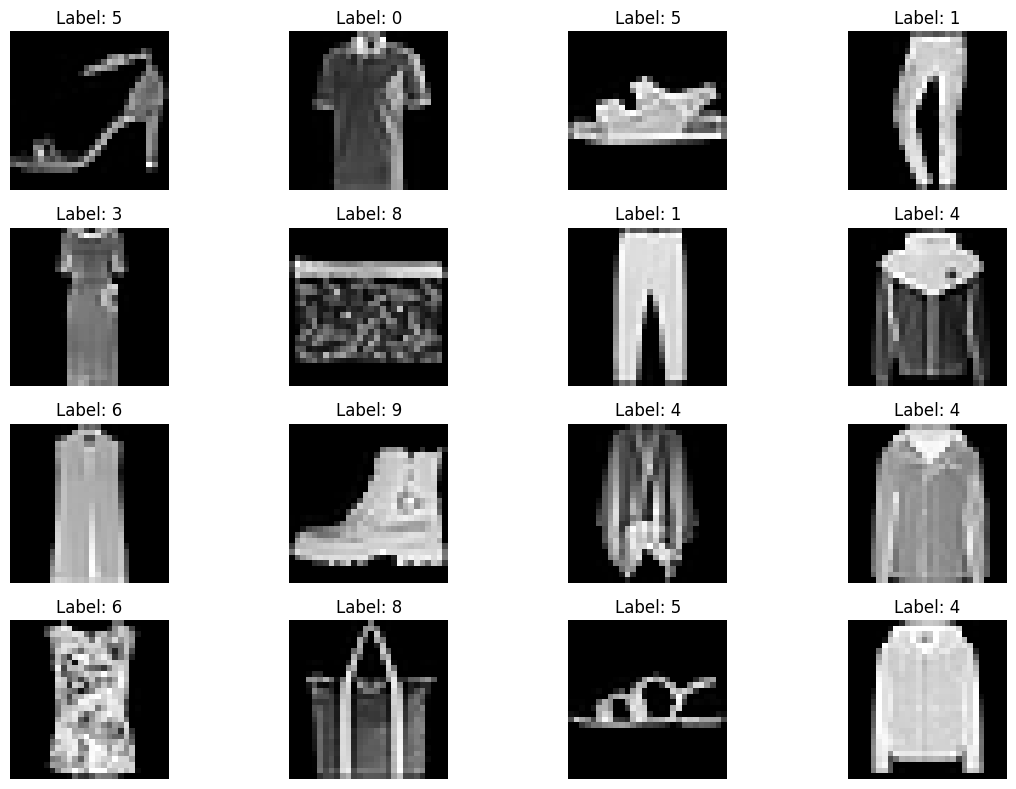

In [17]:
# Display some sample images from the dataset
plt.figure(figsize=(12, 8))

# Get a batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display first 16 images
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 1. Définition de la classe VAE
Dans cette section, nous allons définir la classe VAE que nous entraînerons et utiliserons pour la génération d'images. Nous choisissons d'entraîner un VAE convolutionnel, avec l'architecture suivante (encore une fois, nous laissons le nombre de dimensions cachées $p$ comme paramètre libre) :
- **L'Encodeur :** L'encodeur sera composé des couches suivantes :
    - Couche de convolution avec 32 filtres, une taille de noyau de 4, un pas de 2 et un rembourrage de 1.
    - Couche BatchNorm conservant le même nombre de caractéristiques
    - Activation ReLU
    - Couche de convolution avec 64 filtres, une taille de noyau de 4, un pas de 2 et un rembourrage de 1.
    - Couche BatchNorm conservant le même nombre de caractéristiques
    - Activation ReLU
    - Couche de convolution avec 128 filtres, une taille de noyau de 3, un pas de 2 et un rembourrage de 1.
    - Couche BatchNorm conservant le même nombre de caractéristiques
    - Couche ReLU

- **L'Espace Latent :** Les sorties de l'encodeur sont converties en vecteur moyen $\mu$ et logarithme du vecteur de variance $\log\sigma^2$, via deux couches entièrement connectées en parallèle. Nous devrons définir :
    - Une couche FC pour mapper la sortie de l'encodeur $E(x)$ vers le vecteur moyen $\mu(x)$.
    - Une couche FC pour mapper la sortie de l'encodeur $E(x)$ vers le vecteur log-variance $\log\sigma^2(x)$.
    - Une couche FC pour mapper l'état caché échantillonné $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ vers l'entrée du décodeur.

- **Le Décodeur.** Le décodeur sera composé des couches suivantes :
    - Couche de déconvolution avec 64 filtres, une taille de noyau de 3, un pas de 2 et un rembourrage de 1.
    - Couche BatchNorm conservant le même nombre de caractéristiques
    - Activation ReLU
    - Couche de déconvolution avec 32 filtres, une taille de noyau de 4, un pas de 2 et un rembourrage de 1.
    - Couche BatchNorm conservant le même nombre de caractéristiques
    - Activation ReLU
    - Couche de déconvolution avec 1 filtre, une taille de noyau de 4, un pas de 2 et un rembourrage de 1.
    - Couche Sigmoïde

In [18]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar


On définit la fonction perte pour le VAE 

In [19]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # Reconstruction loss = BCE
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL divergence pour régularisation par rapport à une normale standard
    return BCE + beta * KLD

Entrainement du modèle VAE 

In [22]:
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

# Initialize the VAE model and the Adam optimizer
vae = ConvVAE(latent_dim=latent_dim)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 288.1962
Epoch 2, Training loss: 270.1488
Epoch 3, Training loss: 267.5150
Epoch 4, Training loss: 266.0934
Epoch 5, Training loss: 265.0776
Epoch 6, Training loss: 264.2395
Epoch 7, Training loss: 263.3704
Epoch 8, Training loss: 262.7776
Epoch 9, Training loss: 262.2872
Epoch 10, Training loss: 261.8997
Epoch 11, Training loss: 261.3434
Epoch 12, Training loss: 260.8795
Epoch 13, Training loss: 260.5824
Epoch 14, Training loss: 260.2453
Epoch 15, Training loss: 259.9742
Epoch 16, Training loss: 259.4850
Epoch 17, Training loss: 259.4119
Epoch 18, Training loss: 259.1023
Epoch 19, Training loss: 258.9122
Epoch 20, Training loss: 258.6350
Epoch 21, Training loss: 258.4444
Epoch 22, Training loss: 258.1677
Epoch 23, Training loss: 258.0948
Epoch 24, Training loss: 257.9322
Epoch 25, Training loss: 257.7268
Epoch 26, Training loss: 257.5246
Epoch 27, Training loss: 257.3186
Epoch 28, Training loss: 257.2448
Epoch 29, Training loss: 257.2227
Epoch 30, Training loss

Nous vérifions d'abord si le modèle VAE a appris des caractéristiques significatives en visualisant un ensemble d'images du jeu de test avec leurs reconstructions respectives.

Nous avons déjà défini une fonction appelée **image_comparison** dans le notebook précédent, qui fait exactement ce que nous voulons. Nous pouvons soit la copier-coller ci-dessous, soit mieux encore, créer un fichier dans le dossier actuel appelé **utils.py**, y copier-coller la fonction avec tous les imports de bibliothèques nécessaires, puis importer la fonction **image_comparison** dans la cellule ci-dessous.

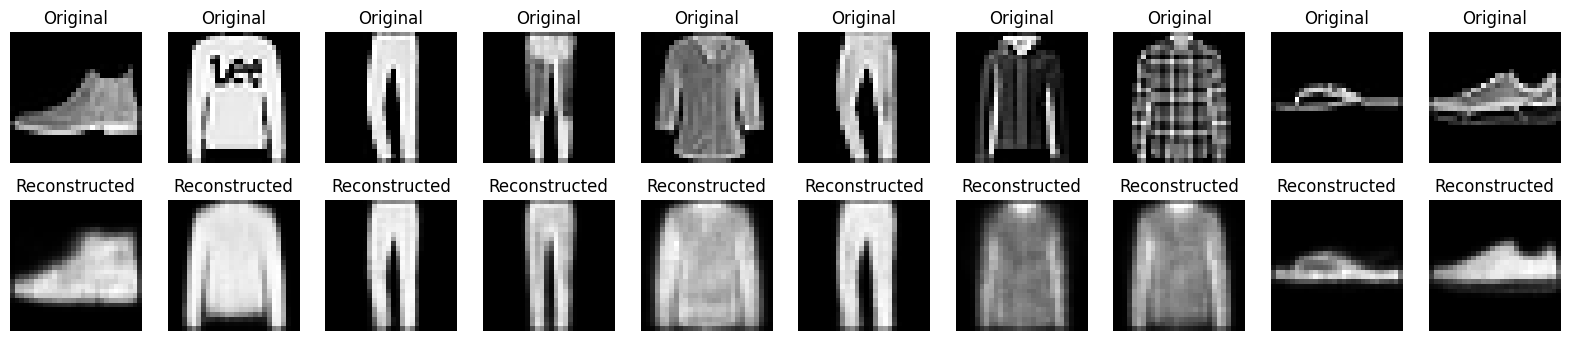

In [23]:
def image_comparison(originals, reconstructions, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Select a batch of images from the test dataset
random_images = next(iter(test_loader))

# Get the reconstructions of the selected images
recons, _, _ = vae(random_images[0].to(device))

# Reshape the images for plotting
random_images = random_images[0].cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

## 2. Define the CVAE class 

### Conditional Variational Autoencoder Architecture

A Conditional Variational Autoencoder (CVAE) extends the standard VAE by conditioning both the encoder and decoder on additional information (labels). The architecture consists of:

**The Conditional Encoder:** The encoder takes both input data and label information to produce latent representations. It consists of:
- Fully connected layer mapping concatenated input (784 image pixels + 10 class labels) to 512 hidden units
- ReLU activation function
- Two parallel fully connected layers:
    - One mapping to latent mean μ (512 → latent_dims)
    - One mapping to latent log-variance log σ² (512 → latent_dims)

**The Latent Space:** Similar to VAE, the latent representation is sampled from a normal distribution:
- Sample z ~ N(μ, σ²) where μ and σ² are outputs from the encoder
- KL divergence is computed between the learned distribution and standard normal prior

In [33]:
class CondVariationalEncoder(nn.Module):
   
    # The encoder gets the label as a one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalEncoder, self).__init__()
        # The dimensions of the one-hot encoding are concatenated to the input
        self.linear1 = nn.Linear(784 + n_classes, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        # Get sampling working on GPU
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
   
    # The labels are provided as variable `y`
    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        x = x.view(-1, 1*28*28)
        # Here the label one-hot encoding is concatenated to the image
        x = F.relu(self.linear1(torch.cat((x,y),dim=1)))
        # Mean
        mu =  self.linear2(x)
        # Variance
        sigma = torch.exp(self.linear3(x))
       
        # Sample latent vector for images
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

**The Conditional Decoder:** The decoder takes both latent samples and label information to reconstruct the input:
- Fully connected layer mapping concatenated input (latent_dims + 10 class labels) to 512 hidden units
- ReLU activation function  
- Output layer mapping to reconstructed image (512 → 784 pixels)
- Sigmoid activation to ensure pixel values are in [0,1] range
- Reshapes output to image dimensions (batch_size, 1, 28, 28)

**Key Architecture Features:**
The key difference from a standard VAE is that both encoder and decoder receive one-hot encoded label information as additional input, allowing the model to:
- Generate samples conditioned on specific classes
- Learn class-specific latent representations
- Control the generation process by specifying desired output labels

In [34]:
class CondVariationalDecoder(nn.Module):
   
    # The decoder gets the label as a one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalDecoder, self).__init__()
        # The dimensions of the one-hot encoding are concatenated to the input
        self.linear1 = nn.Linear(latent_dims + n_classes, 512)
        self.linear2 = nn.Linear(512, 784)
       
    # Labels are provided as variable `y`
    def forward(self, z, y):
        # Here the label one-hot encoding is concatenated to the image
        z = F.relu(self.linear1(torch.cat((z,y),dim=1)))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

We combine into one module 

In [35]:
class CondVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalAutoencoder, self).__init__()
        self.encoder = CondVariationalEncoder(latent_dims, n_classes)
        self.decoder = CondVariationalDecoder(latent_dims, n_classes)
   
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)

We need one more wrapper using Lightning framework 

In [36]:
class CVAEModel(pl.LightningModule):
    def __init__(self, latent_dims, n_classes, train_loader):
        super().__init__()
        self.cvae = CondVariationalAutoencoder(latent_dims, n_classes)
        self.n_classes = n_classes
        self.train_loader = train_loader

    # Lightning requires a training step function in which the forward 
    # step is executed and loss calculated
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_oh = F.one_hot(y, num_classes=self.n_classes)
       
        x_hat = self.cvae(x, y_oh)
        loss = loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl
       
        self.log('Training loss', loss, on_step=False, on_epoch=True,
                 logger=False, prog_bar=True)
       
        return loss
   
    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    # Defining the train dataloader
    def train_dataloader(self):
        return self.train_loader

Entrainement du modèle 

In [37]:
latent_dims=2
model = CVAEModel(latent_dims=latent_dims, n_classes=10, train_loader=train_loader)
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=10)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                       | Params | Mode 
------------------------------------------------------------
0 | cvae | CondVariationalAutoencoder | 817 K  | train
------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.272     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                       | Params | Mode 
------------------------------------------------------------
0 | cvae | CondVariationalAutoencoder | 817 K  | train
------------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [40]:
def image_comparison(originals, reconstructions, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Select a batch of images from the test dataset
random_images, labels = next(iter(test_loader))

# Move to device and convert labels to one-hot encoding
random_images = random_images.to(device)
labels_oh = F.one_hot(labels, num_classes=10).float().to(device)

# Get the reconstructions of the selected images
recons = model.cvae(random_images, labels_oh)

# Reshape the images for plotting
random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)